In [59]:
import numpy as np
import pandas as pd   # We import Pandas!
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import linear_model
import torch
import itertools

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, Predictive
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## 1. Initial Processing

In [2]:
# Set your own path
path = 'data/CA_final.csv'

df = pd.read_csv(path)
df.head()

In [4]:
len(df)

1741433

We've got 1.7M accident records in CA.

In [5]:
df.groupby('Year')['ID'].size()

Year
2016    140452
2017    152748
2018    156898
2019    213455
2020    285532
2021    341876
2022    375913
2023     74559
Name: ID, dtype: int64

In [7]:
df_2022 = df[df['Year'] == 2022]
df_2022.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Hour,Minute,Wind_Speed(mph)_Imputed,Humidity(%)_Imputed,Temperature(F)_Imputed,Visibility(mi)_Imputed,Pressure(in)_Imputed,geohash4,Wind_Direction_Imputed,Weather_Condition_Imputed
175167,A-512231,Source2,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,NaN,NaN,0.0,...,2,2,6.0,28.0,86.0,10.0,27.35,9qhh,E,Thunderstorms and Rain
175168,A-512257,Source2,1,2022-09-08 02:02:58,2022-09-08 02:32:20,34.177322,-118.877014,NaN,NaN,0.0,...,2,2,3.0,87.0,68.0,9.0,29.78,9q56,WNW,Thunderstorms and Rain
175169,A-512277,Source2,3,2022-09-07 21:54:19,2022-09-07 22:38:20,38.593945,-121.504059,NaN,NaN,0.0,...,21,54,0.0,28.0,83.0,10.0,29.83,9qce,VAR,Thunderstorms and Rain
175170,A-512340,Source2,2,2022-09-08 02:03:43,2022-09-08 02:33:13,33.850147,-117.875938,NaN,NaN,0.0,...,2,3,0.0,66.0,79.0,10.0,29.76,9qh0,VAR,Thunderstorms and Rain
175171,A-512341,Source3,1,2022-09-08 02:30:59,2022-09-08 03:00:27,33.884056,-118.029007,NaN,NaN,0.0,...,2,30,0.0,66.0,78.0,10.0,29.74,9qh0,VAR,Thunderstorms and Rain


In [8]:
df_2022['Start_Time'].min(), df_2022['Start_Time'].max()

('2022-01-01 00:02:00', '2022-12-31 23:59:00')

In [11]:
# Saving data for 2022 to lighten memory.
save_path = 'data/data_2022.csv'
df_2022.to_csv(save_path)

If you have already saved data for 2022 start here

In [3]:
# Load 2022 data
load_path = 'data/data_2022.csv'
df = pd.read_csv(load_path)

In [4]:
len(df)

375913

In [16]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])

In [5]:
# Creating a time range with index representing consecutive hours in 2022
start_time = pd.Timestamp('2022-01-01 00:00:00')
end_time = pd.Timestamp('2022-12-31 23:00:00')
hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')
hourly_df = pd.DataFrame(hourly_range, columns=['hour'])
hourly_df['hour_index'] = range(1, len(hourly_range) + 1)


C:\Users\balda\AppData\Local\Temp\ipykernel_20292\2312101316.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')


In [6]:
hourly_df.head()

,hour,hour_index
0,2022-01-01 00:00:00,1
1,2022-01-01 01:00:00,2
2,2022-01-01 02:00:00,3
3,2022-01-01 03:00:00,4
4,2022-01-01 04:00:00,5


In [24]:
len(hourly_df)

8760

In [7]:
geohashes = df['geohash5'].unique()
multi_index = pd.MultiIndex.from_product([hourly_range, geohashes], names=['hour', 'geohash5'])
multi_index_df = pd.DataFrame(index=multi_index).reset_index()

In [8]:
multi_index_df.head()

,hour,geohash5
0,2022-01-01,9qhh7
1,2022-01-01,9q56q
2,2022-01-01,9qcee
3,2022-01-01,9qh0t
4,2022-01-01,9qh0f


In [57]:
# Step 6: Count accidents per hour and geohash
accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')

# Step 7: Merge the multi-index DataFrame with the accident counts
merged_df = pd.merge(multi_index_df, accident_counts, how='left', left_on=['hour', 'geohash5'], right_on=['Start_Time', 'geohash5'])

C:\Users\balda\AppData\Local\Temp\ipykernel_20292\3631858385.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  accident_counts = df.groupby([pd.Grouper(key='Start_Time', freq='H'), 'geohash5']).size().reset_index(name='accident_count')


Let's add one_hot_encoded features for hour of the day and day of the week.

In [58]:
merged_df = merged_df.drop(columns=['Start_Time']).fillna(value=0)

# Assuming 'df' is your DataFrame with the structure you provided
# If not already in datetime format, ensure 'hour' is in datetime format
merged_df['hour'] = pd.to_datetime(merged_df['hour'])

# Step 1: Extract hour of the day and day of the week
merged_df['hour_of_day'] = merged_df['hour'].dt.hour
merged_df['day_of_week'] = merged_df['hour'].dt.dayofweek  # Monday=0, Sunday=6

# Step 2: Generate one-hot encoded columns
hour_dummies = pd.get_dummies(merged_df['hour_of_day'], prefix='hour')
day_dummies = pd.get_dummies(merged_df['day_of_week'], prefix='day')

# Step 3: Concatenate these new columns to the original DataFrame
merged_df = pd.concat([merged_df, hour_dummies, day_dummies], axis=1)

# Display the final DataFrame
print(merged_df)

                        hour geohash5  accident_count  hour_of_day  \
0        2022-01-01 00:00:00    9qhh7             0.0            0   
1        2022-01-01 00:00:00    9q56q             1.0            0   
2        2022-01-01 00:00:00    9qcee             0.0            0   
3        2022-01-01 00:00:00    9qh0t             0.0            0   
4        2022-01-01 00:00:00    9qh0f             0.0            0   
...                      ...      ...             ...          ...   
63448675 2022-12-31 23:00:00    9r4rr             0.0           23   
63448676 2022-12-31 23:00:00    9r354             0.0           23   
63448677 2022-12-31 23:00:00    9r3q8             0.0           23   
63448678 2022-12-31 23:00:00    9r4n7             0.0           23   
63448679 2022-12-31 23:00:00    9r0wf             0.0           23   

          day_of_week  hour_0  hour_1  hour_2  hour_3  hour_4  ...  hour_21  \
0                   5    True   False   False   False   False  ...    False   
1

There's a lot of hashes and a lot of hours so let's take just one hash for now and try to model it. Going for hash `9q5cw` - one with the most accidents in 2022.

In [180]:
merged_df.to_csv('data/merged_df.csv')

In [39]:
merged_df = pd.read_csv('data/merged_df.csv', index_col=[0])

In [40]:
one_hash_df = merged_df[merged_df['geohash5'] == '9q5cw']

In [41]:
one_hash_df

,hour,geohash5,accident_count,hour_of_day,day_of_week,hour_0,hour_1,hour_2,hour_3,hour_4,...,hour_21,hour_22,hour_23,day_0,day_1,day_2,day_3,day_4,day_5,day_6
116,2022-01-01,9q5cw,0.0,0,5,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
7359,2022-01-01 01:00:00,9q5cw,0.0,1,5,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
14602,2022-01-01 02:00:00,9q5cw,0.0,2,5,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
21845,2022-01-01 03:00:00,9q5cw,2.0,3,5,False,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
29088,2022-01-01 04:00:00,9q5cw,0.0,4,5,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63412581,2022-12-31 19:00:00,9q5cw,4.0,19,5,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
63419824,2022-12-31 20:00:00,9q5cw,3.0,20,5,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
63427067,2022-12-31 21:00:00,9q5cw,0.0,21,5,False,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
63434310,2022-12-31 22:00:00,9q5cw,7.0,22,5,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False


## 2. Training

The code I am using here is from exercise 06 Part 2.

In [42]:
# Define target
y = np.array(one_hash_df['accident_count'], dtype=np.float16)
X = np.array(one_hash_df.drop(columns=['hour', 'geohash5', 'accident_count', 'hour_of_day', 'day_of_week']), dtype=np.float16)

# Split into train and test
N = len(X)
split_idx = int(0.8*N)
X_train = X[:split_idx,:]
y_train = y[:split_idx]
X_test = X[split_idx:,:]
y_test = y[split_idx:]

print(' X_train:', X_train.shape, '\n', 'X_test:', X_test.shape, '\n', 'y_train:', y_train.shape, '\n', 'y_test:', y_test.shape)

 X_train: (7008, 31) 
 X_test: (1752, 31) 
 y_train: (7008,) 
 y_test: (1752,)


In [43]:
# standardize input features
X_train_mean = X_train.mean(axis=0)
X_test_mean = X_test.mean(axis=0)

X_train_std = X_train.std()
X_test_std = X_test.std()

X_train = (X_train - X_train_mean) / X_train_std
X_est = (X_test - X_test_mean) / X_test_std

In [47]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [48]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In [49]:
def poisson_model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Poisson(torch.exp(alpha + X.matmul(beta))), obs=obs)
        
    return y

In [60]:
# Define guide function
guide = AutoDiagonalNormal(poisson_model)

# Reset parameter values
pyro.clear_param_store()

In [62]:
# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(poisson_model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 9258.0
[500] ELBO: 7212.3
[1000] ELBO: 6562.6
[1500] ELBO: 6448.8
[2000] ELBO: 6442.2
[2500] ELBO: 6432.7
[3000] ELBO: 6432.9
[3500] ELBO: 6422.9
[4000] ELBO: 6422.1
[4500] ELBO: 6425.4
[5000] ELBO: 6425.1
[5500] ELBO: 6425.0
[6000] ELBO: 6426.9
[6500] ELBO: 6425.3
[7000] ELBO: 6425.7
[7500] ELBO: 6428.4
[8000] ELBO: 6423.8
[8500] ELBO: 6424.9
[9000] ELBO: 6425.6
[9500] ELBO: 6427.3


In [63]:
predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [64]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(np.exp(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T)), axis=1)

# convert back to the original scale
preds = y_hat # no need to do any conversion here because the Poisson model received untransformed y's

corr, mae, rae, rmse, r2 = compute_error(y_test, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.155
MAE: 0.741
RMSE: 0.902
R2: 0.000


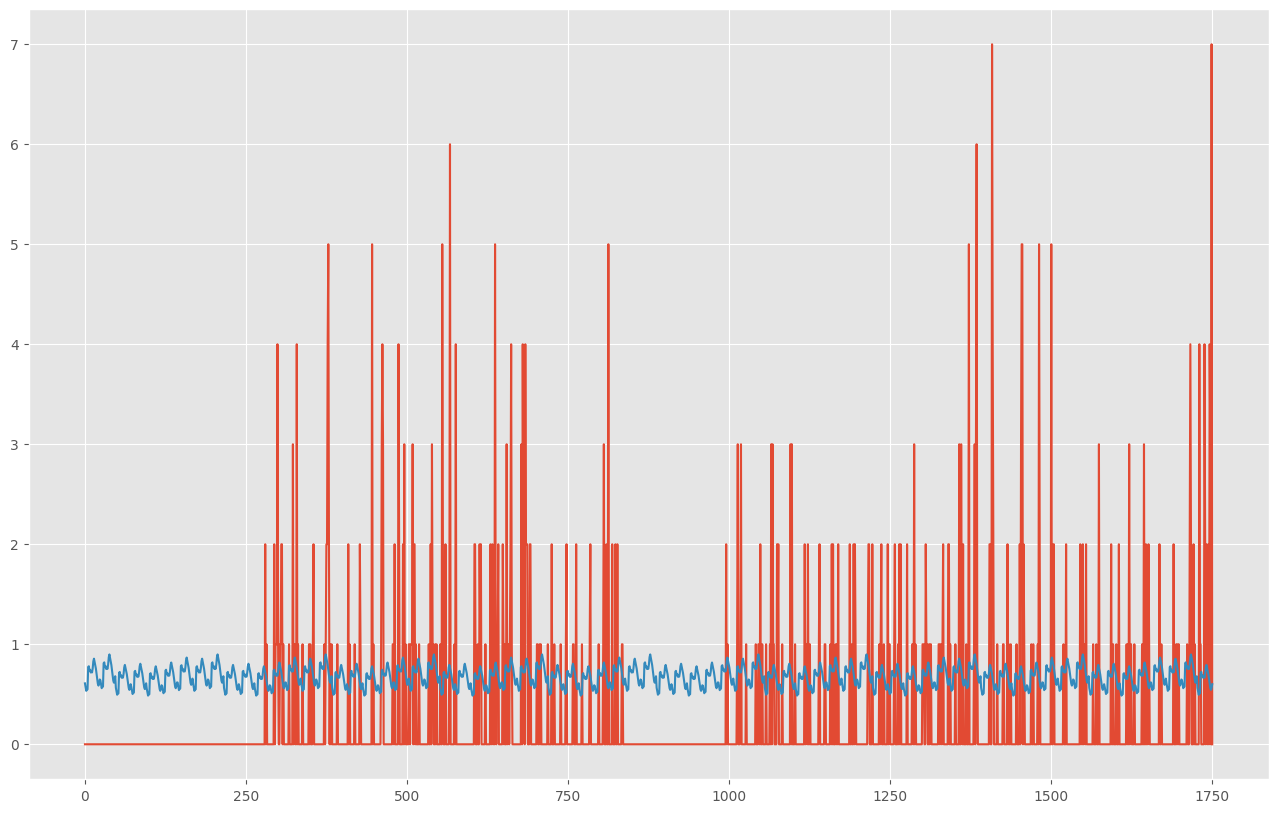

In [65]:
plt.plot(y_test)
plt.plot(y_hat)